In [1]:
import numpy as np
import scipy.integrate as spi
import scipy.optimize as spo
import matplotlib.pyplot as plt
import os
import pickle

### Plotting Utilities

In [2]:
# Set the ticks as functions of pi
def pi_formatter(x, pos):
    fractions = {0: '0', np.pi/4: r'$\pi/4$', np.pi/2: r'$\pi/2$', 
                 3*np.pi/4: r'$3\pi/4$', np.pi: r'$\pi$'}
    return fractions.get(x, f'{x/np.pi:.2g}π')

def plot_pdf_and_fit(alpha_values, noise, exponent):

    plt.figure(figsize=(10, 6))
    
    colormap = plt.cm.RdYlBu
    num_colors = len(alpha_values)
    extreme_indices = np.concatenate([
        np.linspace(0, 0.3, num_colors // 2, endpoint=False),  # Lower 30%
        np.linspace(0.7, 1.0, num_colors - num_colors // 2)    # Upper 30%
    ])
    colors = [colormap(i) for i in extreme_indices]
    
    # Insert a unique color for the central aspect ratio
    central_color = 'black'
    central_ap = 1.0  # Replace with the actual central value of aspect ratio
    
    try:
        central_index = alpha_values.index(central_ap)
    except ValueError:  # Raised if central_ap is not in alpha_values
        central_index = 0
    # Insert the central color
    colors.insert(central_index, central_color)
    # Plot the fit results
    for i, alpha in enumerate(alpha_values):
        # Solve the model with optimized parameters
        theta_x, model_solution = solve_for_alpha_fit(alpha, optimized_noise, optimized_exponent)
    
        # Get the actual data for this alpha value
        actual_theta_x, actual_p = actual_data[i]
    
        # Plot the actual data
        plt.plot(actual_theta_x, actual_p, 'o', markersize = 0.5, label=f"Actual Data (α = {alpha})", color=colors[i])
    
        # Plot the model solution
        plt.plot(theta_x, model_solution, '-', label=f"Fit (α = {alpha})", color=colors[i])
    
    # Customize the plot
    plt.xlabel('$\\theta_x$ [rad]', fontsize=30)
    plt.ylabel('$\\psi[\\theta_x]$', fontsize=30)
    plt.gca().xaxis.set_major_locator(MultipleLocator(base=np.pi/4))
    plt.gca().xaxis.set_major_formatter(FuncFormatter(pi_formatter))
    plt.gca().tick_params(axis='x', labelsize=14)
    plt.gca().tick_params(axis='y', labelsize=14)
    
    plt.title(f'Circular PDF of Angular Distribution ($\\mu_p={cof}$, $I={I}$) and fit Fokker-Planck', fontsize=16)
    plt.grid(True)
    plt.show()

## Reading the data from simulations

*change the input directory and the logic to read data from other files*

In [3]:
def read_pdf_theta(directory, fixed_cof, fixed_I, aspect_ratios, direction):
    
    os.chdir(directory)
    #initilize data list
    actual_data = []
    # Loop over the aspect ratios (ap)
    for idx, ap in enumerate(aspect_ratios):
        filename = f'simple_shear_ap{ap}_cof_{fixed_cof}_I_{fixed_I}.pkl'
        if os.path.exists(filename):
            with open(filename, 'rb') as file:
                file_data = pickle.load(file)
                if direction == 'x':
                    pdf_data = file_data.get('pdf_thetax', None)
                elif direction == 'z':
                    pdf_data = file_data.get('pdf_thetaz', None)
                else:
                    raise ValueError("Invalid direction. Choose either 'x' or 'z'.")

                if pdf_data is not None and pdf_data.shape == (180, 2):
                    pdf_values = pdf_data[:, 1]  # The PDF values
                    bin_centers = pdf_data[:, 0]  # The bin centers
                    if ap<1:
                        bin_centers = bin_centers + np.pi/2
                        bin_centers = np.where(bin_centers>np.pi/2, bin_centers-np.pi, bin_centers)
                          # Sort the data to avoid crossing boundaries
                        sorted_indices = np.argsort(bin_centers)
                        bin_centers = bin_centers[sorted_indices]
                        pdf_values = pdf_values[sorted_indices]
                    reshaped_tuple = tuple((bin_centers, pdf_values))
                    actual_data.append(reshaped_tuple)

    return actual_data



def read_data_key(key, directory, fixed_cof, fixed_I, aspect_ratios):
    """
    Read the data from the pickle files with the given key.
    """
    os.chdir(directory)
    # Initialize the data list
    actual_data = []
    # Loop over the aspect ratios (ap)
    for idx, ap in enumerate(aspect_ratios):
        filename = f'simple_shear_ap{ap}_cof_{fixed_cof}_I_{fixed_I}.pkl'
        if os.path.exists(filename):
            with open(filename, 'rb') as file:
                file_data = pickle.load(file)
                # Extract the data
                data = file_data.get(key, None)
                if data is not None:
                    actual_data.append(data)
    return actual_data

Optimizing parameters for alpha = 1.0
Alpha: 1.0, r: 0.006797841830383841, theta_d: -0.11963810663417883, U: 2.0000115526411135
Optimizing parameters for alpha = 1.2
Alpha: 1.2, r: 0.5733202463036057, theta_d: 0.5260656119221039, U: 2.08107122241454
Optimizing parameters for alpha = 1.5
Alpha: 1.5, r: 1.224737051811855, theta_d: 0.4172041985027747, U: 2.353556025731425
Optimizing parameters for alpha = 1.8
Alpha: 1.8, r: 1.9329783720358527, theta_d: 0.3863196603458893, U: 2.8158847092866424
Optimizing parameters for alpha = 2.0
Alpha: 2.0, r: 2.4033174799344015, theta_d: 0.3587237854548434, U: 3.1871798307433714
Optimizing parameters for alpha = 2.5
Alpha: 2.5, r: 3.358451424241977, theta_d: 0.3203893305197547, U: 4.030042612444463
Optimizing parameters for alpha = 3.0
Alpha: 3.0, r: 4.451403527622987, theta_d: 0.30326396302013603, U: 5.064827738591748


/tmp/ipykernel_52426/2850574901.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  predicted_theta = 0.5*np.arccos(U/(r*beta)*(1-1/g_r))
/tmp/ipykernel_52426/2850574901.py:45: RuntimeWarning: invalid value encountered in arccos
  predicted_theta = 0.5*np.arccos(U/(r*beta)*(1-1/g_r))
/tmp/ipykernel_52426/2850574901.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  strength = (U / (r * beta)) * ((1 - 1 / g_r) / cos_2theta_d)
/tmp/ipykernel_52426/2850574901.py:53: RuntimeWarning: invalid value encountered in scalar multiply
  theta_predicted = 0.5 * np.arccos(U / (r * beta * strength) * (1 - 1 / g_r))


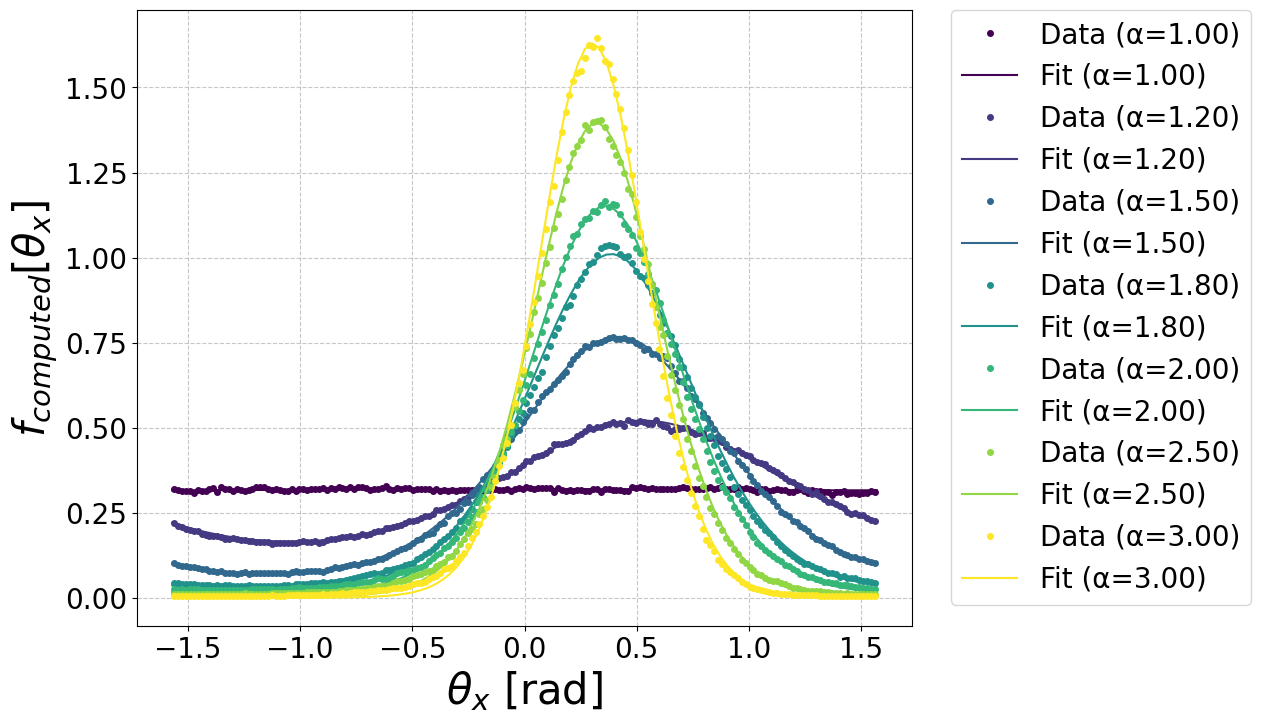

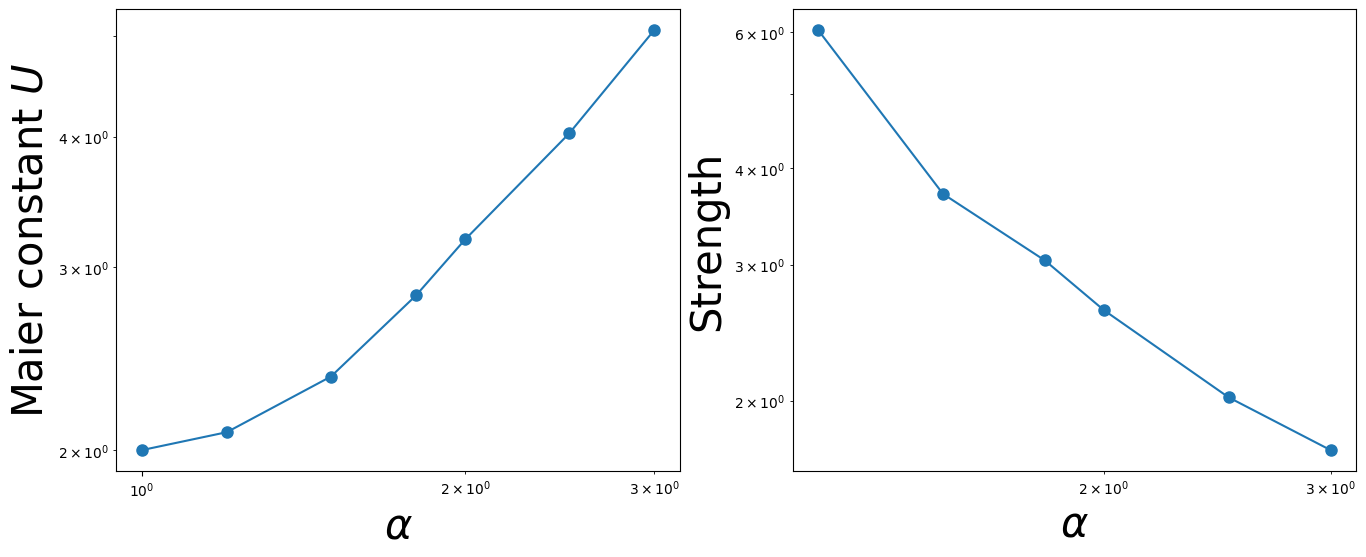

In [4]:
# Define the function to fit
def fit_function(x, r, theta_d):
    """ Model function with r and theta_d as parameters. """
    numerator = np.exp(r * np.cos(2 * (x - theta_d)))
    
    # Compute denominator numerically
    denominator, _ = spi.quad(lambda t: np.exp(r * np.cos(2 * (t - theta_d))), -np.pi/2, np.pi/2)
    
    return numerator / denominator

cof = 0.4
I=0.01
intitial_guess = [3]
alpha_values = [1.0, 1.2, 1.5, 1.8, 2.0, 2.5, 3.0]

directory = "/home/jacopo/Documents/phd_research/Data_processing_simple_shear/output_data_26_02_2025/"

actual_data = read_pdf_theta(directory, cof, I, alpha_values, 'x')
phis = read_data_key('phi', directory, cof, I, alpha_values)
# Optimize r and theta_d for each alpha value
optimized_params = []
for i, alpha in enumerate(alpha_values):
    actual_x, actual_p = actual_data[i]  # Extract data for this alpha
    
    print(f"Optimizing parameters for alpha = {alpha}")
    # Perform the curve fitting
    initial_guess = [1.0, 0.0]  # Example initial guesses for r and theta_d
    popt, _ = spo.curve_fit(fit_function, actual_x, actual_p, p0=initial_guess)
    
    r = popt[0]
    theta_d = popt[1]
    x_fit = np.linspace(-np.pi/2, np.pi/2, 500)
    y_fit = fit_function(x_fit, r, theta_d)
    U = r / np.trapezoid(np.cos(2 * (x_fit - theta_d)) * y_fit, x_fit) 
    
    # expected_theta_d = np.arccos(factor)/2
    print(f"Alpha: {alpha}, r: {r}, theta_d: {theta_d}, U: {U}")
    g_r = (np.trapezoid(np.exp(r*np.cos(2*x_fit)), x_fit)/np.pi)**2
    # print(f"g(r) is {g_r}")
    # if alpha > 1:
    beta = (alpha**2-1)/(alpha**2+1)

    # print(f"beta*r/U is {beta*r/U}")
    # print(f"beta is {beta}")
    predicted_theta = 0.5*np.arccos(U/(r*beta)*(1-1/g_r))
    # print(f"The predicted theta is {predicted_theta}")

    # Compute the required "strength" to match theta_d
    cos_2theta_d = 2 * np.cos(theta_d) ** 2 - 1
    strength = (U / (r * beta)) * ((1 - 1 / g_r) / cos_2theta_d) 

    # Compute predicted theta with the corrected equation
    theta_predicted = 0.5 * np.arccos(U / (r * beta * strength) * (1 - 1 / g_r))
    # Store the optimized parameters
    optimized_params.append({'alpha': alpha, 'r': r, 'theta_d': theta_d, 'U': U, 'strength': strength})



# Plot the actual data and fits
plt.figure(figsize=(10, 8))
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1, len(alpha_values))]

for i, result in enumerate(optimized_params):
    alpha = result['alpha']
    r = result['r']
    theta_d = result['theta_d']
    
    # Generate model predictions
    x_fit = np.linspace(-np.pi/2, np.pi/2, 100)
    y_fit = fit_function(x_fit, r, theta_d)
    
    # Plot actual data
    actual_x, actual_p = actual_data[i]
    plt.plot(actual_x, actual_p, 'o', markersize=4, label=f"Data (α={alpha:.2f})", color=colors[i])
    
    # Plot fitted function
    plt.plot(x_fit, y_fit, '-', label=f"Fit (α={alpha:.2f})", color=colors[i])

plt.xlabel('$\\theta_x$ [rad]', fontsize=30)
plt.ylabel('$f_{computed}[\\theta_x]$', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.title('Fit of the Circular PDF', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.7)
# plt.legend(fontsize=30, loc='outside')
plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

# plot U as a function of alpha
alphas = [result['alpha'] for result in optimized_params]
Us = [result['U'] for result in optimized_params]
strengths = [result['strength'] for result in optimized_params]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].loglog(alphas, Us, 'o-', markersize=8)
axes[0].set_xlabel('$\\alpha$', fontsize=30)
axes[0].set_ylabel('Maier constant $U$', fontsize=30)
axes[1].loglog(alphas, strengths, 'o-', markersize=8)
axes[1].set_xlabel('$\\alpha$', fontsize=30)
axes[1].set_ylabel('Strength', fontsize=30)

plt.show()



/tmp/ipykernel_52426/3969933151.py:45: RuntimeWarning: invalid value encountered in arccos
  predicted_theta = 0.5 * np.arccos(U / (r * beta) * (1 - 1 / g_r))


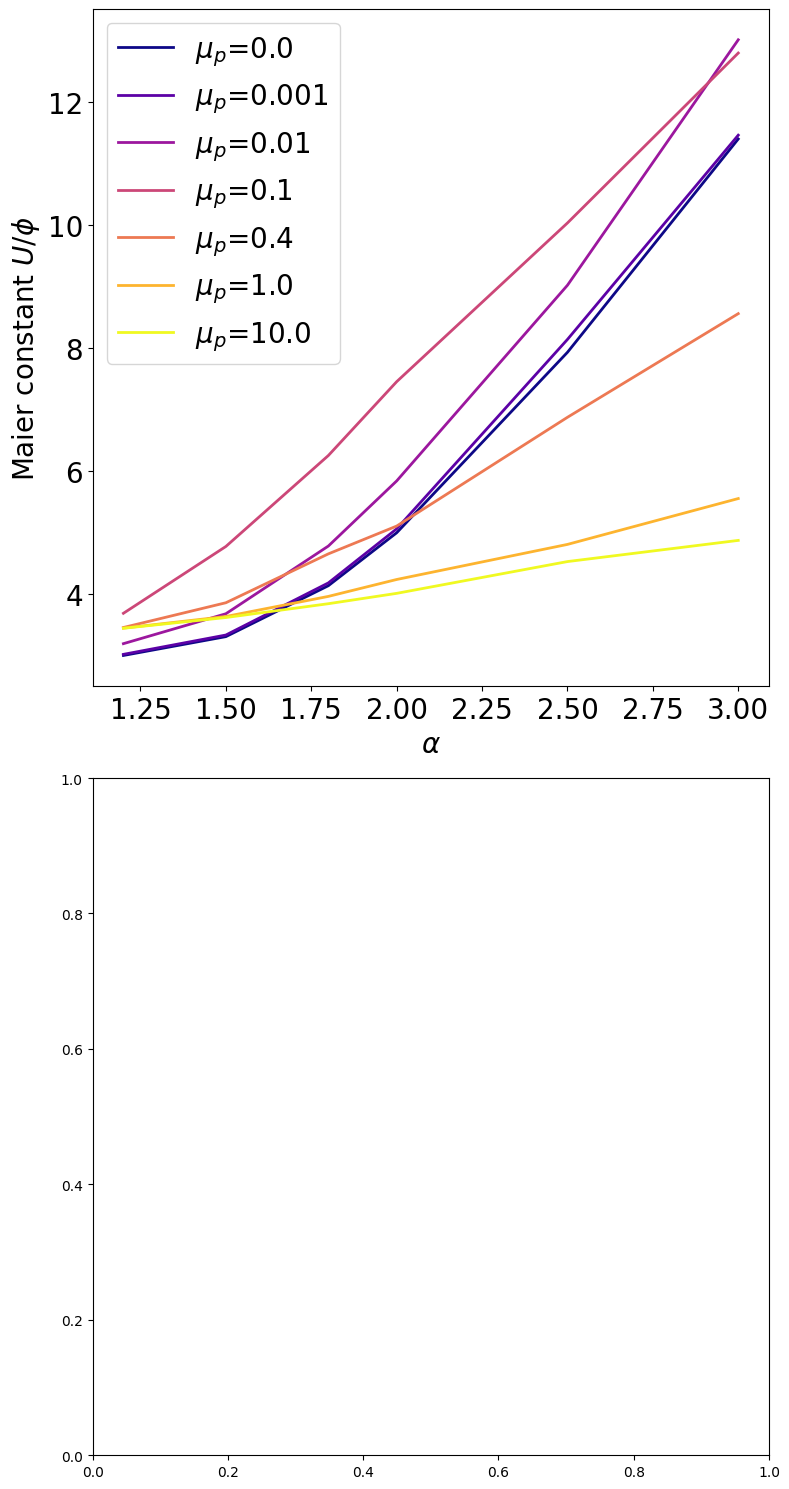

In [5]:

# Define the values of mu_p (previously cof) and I to loop over
mu_p_values = [0.0, 0.001, 0.01, 0.1, 0.4, 1.0, 10.0]
I_values = [0.1, 0.046, 0.022, 0.01, 0.0046, 0.0022, 0.001]
I_values = [0.001]
alpha_values = [1.2, 1.5, 1.8, 2.0, 2.5, 3.0]
directory = "/home/jacopo/Documents/phd_research/Data_processing_simple_shear/output_data_final/"

# Dictionary to store results for each mu_p and I
all_results = {}

# Loop over mu_p values
for mu_p in mu_p_values:
     
    all_results[mu_p] = {}
    
    # Loop over I values
    for I in I_values:
        actual_data = read_pdf_theta(directory, mu_p, I, alpha_values, "x")
        phis = read_data_key('phi', directory, mu_p, I, alpha_values)

        optimized_params = []

        # Optimize r and theta_d for each alpha
        for i, alpha in enumerate(alpha_values):
            actual_x, actual_p = actual_data[i]  # Extract data for this alpha
            
            # Perform the curve fitting
            initial_guess = [1.0, 0.0]  # Example initial guesses for r and theta_d
            popt, _ = spo.curve_fit(fit_function, actual_x, actual_p, p0=initial_guess)
            
            r = popt[0]
            theta_d = popt[1]
            
            # Compute U and rescale it by phi
            phi = phis[i]  # Get corresponding phi value
            x_fit = np.linspace(-np.pi/2, np.pi/2, 500)
            y_fit = fit_function(x_fit, r, theta_d)
            U = (r / np.trapezoid(np.cos(2 * (x_fit - theta_d)) * y_fit, x_fit)) / phi

            # Compute g(r)
            g_r = (np.trapezoid(np.exp(r * np.cos(2 * x_fit)), x_fit) / np.pi) ** 2

            # Compute beta and predicted theta
            beta = (alpha**2 - 1) / (alpha**2 + 1)
            predicted_theta = 0.5 * np.arccos(U / (r * beta) * (1 - 1 / g_r))
            # Compute the required "strength" to match theta_d
            cos_2theta_d = 2 * np.cos(theta_d) ** 2 - 1
            strength = (U / (r * beta)) * ((1 - 1 / g_r) / cos_2theta_d) 
            strength /= phi  # Rescale by phi

            # Store results
            optimized_params.append({
                'alpha': alpha,
                'r': r,
                'theta_d': theta_d,
                'U': U,
                'predicted_theta': predicted_theta,
                'strength': strength, 
            })

        # Store results for this mu_p and I
        all_results[mu_p][I] = optimized_params
# -------------------------------------------------
# Create one figure per I, each with two subplots
# -------------------------------------------------
colormap = plt.cm.plasma  # Better colormap for perceptual clarity
colors = [colormap(i) for i in np.linspace(0, 1, len(mu_p_values))]

for I in I_values:
    fig, axes = plt.subplots(2, 1, figsize=(8, 15))#, sharex=True)
    
    # Plot U vs alpha
    for j, mu_p in enumerate(mu_p_values):
        results = all_results[mu_p][I]
        alphas = [result['alpha'] for result in results]
        Us = [result['U'] for result in results]

        alphas = np.array(alphas)
        # axes[0].loglog(alphas, Us, 'o:', markersize=6, color=colors[j], label=f"$\\mu_p$={mu_p}")
        # popt, _ = spo.curve_fit(lambda x, a, b: a * x**b, alphas[1:], Us[1:], p0=[1.0, 1.0])
        # axes[0].loglog(alphas[1:], popt[0] * alphas[1:]**popt[1], '-', color=colors[j], label=f"Fit $\\propto \\alpha^{{{popt[1]:.2f}}}$")

        # plot in linear scale
        axes[0].plot(alphas, Us, '-', markersize=6, linewidth = 2,  color=colors[j], label=f"$\\mu_p$={mu_p}")
        # popt, _ = spo.curve_fit(lambda x, a, b: a * x + b, alphas[1:], Us[1:], p0=[1.0, 1.0])
        # axes[0].plot(alphas[1:], popt[0] * alphas[1:] + popt[1], '-', color=colors[j], label=f"Fit $\\propto \\alpha^{{{popt[1]:.2f}}}$")
        # axes[0].set_xlabel('$\\alpha$', fontsize=14)
    
    axes[0].set_ylabel('Maier constant $U / \\phi$', fontsize=20)
    axes[0].set_xlabel('$\\alpha$', fontsize=20)
    axes[0].tick_params(axis='both', which='major', labelsize=20)
    # axes[0].set_title(f'Maier constant $U / \\phi$ vs. Aspect Ratio $\\alpha$ (I={I})', fontsize=16)
    axes[0].legend(fontsize=20, loc='best')
    
    #     # Plot theta_d vs alpha
    # for j, mu_p in enumerate(mu_p_values):
    #     results = all_results[mu_p][I]
    #     alphas = [result['alpha'] for result in results]
    #     theta_ds = [result['theta_d'] for result in results]
    #     predicted_theta_ds = [result['predicted_theta'] for result in results]  # Extract predicted theta values
    #     print(f"predicted_theta_ds: {predicted_theta_ds}")
    #     # Plot actual theta_d
    #     axes[1].plot(alphas, theta_ds, 'o:', markersize=6, color=colors[j], label=f"$\\mu_p$={mu_p} (Fitted)")
        
    #     # Plot predicted theta
    #     # axes[1].plot(alphas[1:], predicted_theta_ds[1:], 's--', markersize=5, color=colors[j], alpha=0.7, label=f"$\\mu_p$={mu_p} (Predicted)")

    # axes[1].set_xlabel('Aspect Ratio $\\alpha$', fontsize=14)
    # axes[1].set_ylabel('$\\theta_d$', fontsize=14)
    # axes[1].set_title(f'Inclination Angle $\\theta_d$ vs. Aspect Ratio $\\alpha$ (I={I})', fontsize=16)
    # axes[1].legend(fontsize=8, loc='best')

    # # Plot strength vs alpha
    # for j, mu_p in enumerate(mu_p_values):
    #     results = all_results[mu_p][I]
    #     alphas = [result['alpha'] for result in results]
    #     strengths = [result['strength'] for result in results]
    #     axes[2].loglog(alphas, strengths, 'o:', markersize=6, color=colors[j], label=f"$\\mu_p$={mu_p}")
    #     # starting from the second value of alpha, provide the best fit power law, with exponent
    #     # for the strength
    #     # popt, _ = spo.curve_fit(lambda x, a, b: a * x**b, alphas[1:], strengths[1:], p0=[1.0, 1.0])
    #     # axes[2].loglog(alphas[1:], popt[0] * alphas[1:]**popt[1], '-', color=colors[j], label=f"Fit $\\propto \\alpha^{{{popt[1]:.2f}}}$")

    # axes[2].set_xlabel('Aspect Ratio $\\alpha$', fontsize=14)
    # axes[2].set_ylabel('Strength', fontsize=14)
    # axes[2].set_title(f'Strength vs. Aspect Ratio $\\alpha$ (I={I})', fontsize=16)
    # axes[2].legend(fontsize=8, loc='best')

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_52426/667160184.py:30: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral = np.trapz(distr, theta)


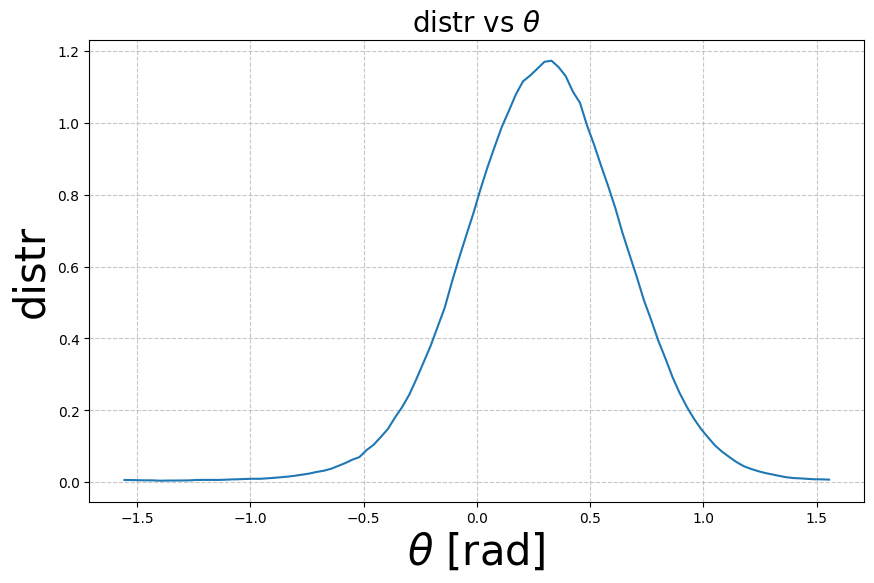

In [12]:
data_martin_directory = "/home/jacopo/Documents/phd_research/Data_processing_simple_shear/"
# read the dat file
os.chdir(data_martin_directory)
data = np.loadtxt("dir_ang_mu_iner.dat")

# enforce symmetry
try:
    if data.shape[0] % 2 == 0:
        half_index = data.shape[0] // 2
        data[:half_index, 2] = data[:half_index, 2]+data[half_index:, 2] 
        data[:half_index, 3] = data[:half_index, 3]+data[half_index:, 3]
        data = data[:half_index]
        data[:, 3] = data[:, 2] + data[:, 3]

except IndexError:
    print("The data is not symmetric")

# convert angle to radians
theta = data[:, 1] * np.pi  / 180
distr = data[:, 2]
distr2 = data[:, 3]

# shift the angle to be in the range [-pi/2, pi/2]
theta = theta - np.pi/2
# theta = - theta
distr = np.roll(distr, -45)


# check if distr is a pdf, if it is not normalize it
integral = np.trapz(distr, theta)
if integral != 1:
    distr = distr / integral

# plot distr and distr2 vs theta in subplots
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(-theta, distr, label='distr')
ax.set_xlabel('$\\theta$ [rad]', fontsize=30)
ax.set_ylabel('distr', fontsize=30)
ax.set_title('distr vs $\\theta$', fontsize=20)
ax.grid(True, linestyle='--', alpha=0.7)



Optimizing parameters for alpha = 3.0
Alpha: 3.0, r: 2.487392228222938, theta_d: 0.30129758011160723, U: 3.257376516514435


/tmp/ipykernel_52426/391048738.py:24: RuntimeWarning: invalid value encountered in arccos
  predicted_theta = 0.5*np.arccos(U/(r*beta)*(1-1/g_r))


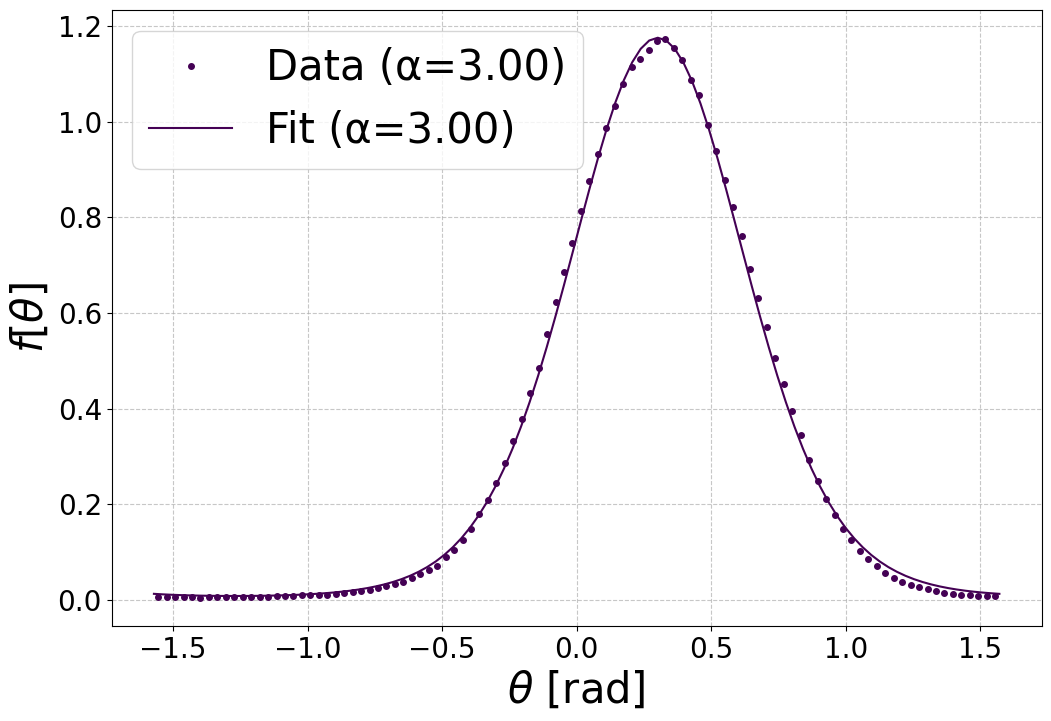

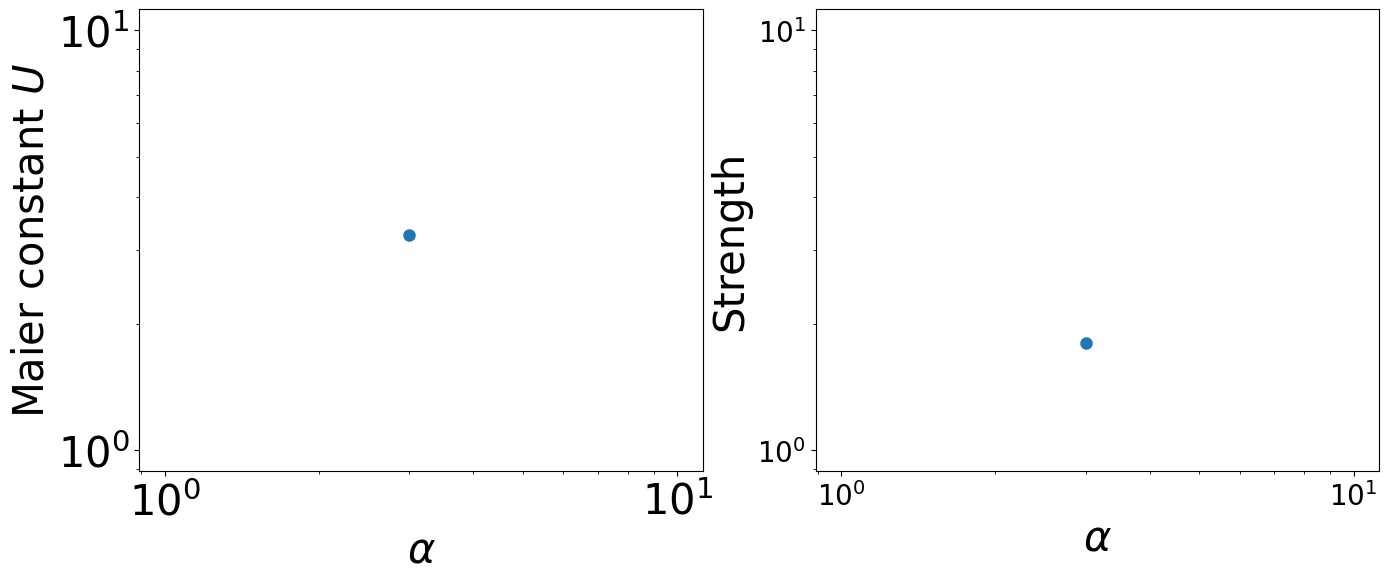

In [13]:

actual_x, actual_p = -theta, distr  # Extract data for this alpha
optimized_params = []
print(f"Optimizing parameters for alpha = {alpha}")
# Perform the curve fitting
initial_guess = [1.0, 0.0]  # Example initial guesses for r and theta_d
popt, _ = spo.curve_fit(fit_function, actual_x, actual_p, p0=initial_guess)


r = popt[0]
theta_d = popt[1]
x_fit = np.linspace(-np.pi/2, np.pi/2, 500)
y_fit = fit_function(x_fit, r, theta_d)
U = r / np.trapezoid(np.cos(2 * (x_fit - theta_d)) * y_fit, x_fit) 

# expected_theta_d = np.arccos(factor)/2
print(f"Alpha: {alpha}, r: {r}, theta_d: {theta_d}, U: {U}")
g_r = (np.trapezoid(np.exp(r*np.cos(2*x_fit)), x_fit)/np.pi)**2
# print(f"g(r) is {g_r}")
# if alpha > 1:
beta = (alpha**2-1)/(alpha**2+1)

# print(f"beta*r/U is {beta*r/U}")
# print(f"beta is {beta}")
predicted_theta = 0.5*np.arccos(U/(r*beta)*(1-1/g_r))
# print(f"The predicted theta is {predicted_theta}")

# Compute the required "strength" to match theta_d
cos_2theta_d = 2 * np.cos(theta_d) ** 2 - 1
strength = (U / (r * beta)) * ((1 - 1 / g_r) / cos_2theta_d) 

# Compute predicted theta with the corrected equation
theta_predicted = 0.5 * np.arccos(U / (r * beta * strength) * (1 - 1 / g_r))
# Store the optimized parameters
optimized_params.append({'alpha': alpha, 'r': r, 'theta_d': theta_d, 'U': U, 'strength': strength})



# Plot the actual data and fits
plt.figure(figsize=(12, 8))
colormap = plt.cm.viridis
colors = [colormap(i) for i in np.linspace(0, 1, len(alpha_values))]

for i, result in enumerate(optimized_params):
    alpha = result['alpha']
    r = result['r']
    theta_d = result['theta_d']
    
    # Generate model predictions
    x_fit = np.linspace(-np.pi/2, np.pi/2, 100)
    y_fit = fit_function(x_fit, r, theta_d)
    
    # Plot actual data
    # actual_x, actual_p = actual_data[i]
    plt.plot(actual_x, actual_p, 'o', markersize=4, label=f"Data (α={alpha:.2f})", color=colors[i])
    
    # Plot fitted function
    plt.plot(x_fit, y_fit, '-', label=f"Fit (α={alpha:.2f})", color=colors[i])
    plt.tick_params(axis='both', labelsize=20)


plt.xlabel('$\\theta$ [rad]', fontsize=30)
# plt.ylabel('$\\psi[\\theta_x]$', fontsize=30)
plt.ylabel('$f [\\theta]$', fontsize=30)
# plt.title('Fit of the Circular PDF', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=30)
plt.show()

# plot U as a function of alpha
alphas = [result['alpha'] for result in optimized_params]
Us = [result['U'] for result in optimized_params]
strengths = [result['strength'] for result in optimized_params]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))


axes[0].loglog(alphas, Us, 'o-', markersize=8)
axes[0].set_xlabel('$\\alpha$', fontsize=30)
axes[0].set_ylabel('Maier constant $U$', fontsize=30)
# increase the size of the font in axis ticks
axes[0].tick_params(axis='both', labelsize=30)

axes[1].loglog(alphas, strengths, 'o-', markersize=8)
axes[1].set_xlabel('$\\alpha$', fontsize=30)
axes[1].set_ylabel('Strength', fontsize=30)
axes[1].tick_params(axis='both', which='major', labelsize=20)

plt.show()

